In [3]:
from PIL import Image
import numpy as np

##### chair의 이미지 해상도를 통일하여 적용하기 : Test

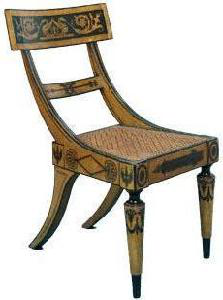

In [4]:
# chair의 1번 이미지
img = Image.open("../Data/chair/image_0001.jpg")
img

In [5]:
# 배열 확인
np.array(img).shape

(300, 223, 3)

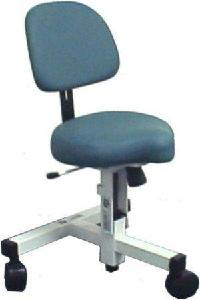

In [6]:
# chair의 2번 이미지
img = Image.open("../Data/chair/image_0002.jpg")
img

In [7]:
# 배열 확인
np.array(img).shape

(300, 200, 3)

> Image의 해상도가 일정하지 않음    
전체 이미지의 해상도의 최대값을 가지고 적용해보자!

##### chair의 전체이미지의 평균 해상도 구하기

In [8]:
import glob

In [9]:
widthRatio = []
heightRatio = []

for file in sorted(glob.glob("../Data/chair/*.jpg")):
    img = np.array(Image.open(file), dtype=np.int32)
    widthRatio.append(img.shape[1])
    heightRatio.append(img.shape[0])

In [10]:
print('chair의 너비 최대 해상도 :', np.mean(widthRatio))
print('chair의 높이 최대 해상도 :', np.mean(heightRatio))

chair의 너비 최대 해상도 : 229.65
chair의 높이 최대 해상도 : 297.31666666666666


> 너비 : 230, 높이 : 298으로 정함!

---
##### chair 이미지 해상도 변경 및 Gray Scale로 적용

In [11]:
i = 1
for file in sorted(glob.glob("../Data/chair/*.jpg")):
    img = Image.open(file)
    imgResize = img.resize((230, 298), Image.Resampling.LANCZOS)
    imgResize = imgResize.convert('L')
    imgResize.save("../Data/chairNew/image_%04d.jpg"%i, "JPEG")
    i += 1

##### Laptop의 이미지 해상도 변경 및 GrayScale 적용

In [12]:
i = 1
for file in sorted(glob.glob("../Data/laptop/*.jpg")):
    img = Image.open(file)
    imgResize = img.resize((230, 298), Image.Resampling.LANCZOS)
    imgResize = imgResize.convert('L')
    imgResize.save("../Data/laptopNew/image_%04d.jpg"%i, "JPEG")
    i += 1

#### chair Image를 Numpy로 변경하기

In [13]:
number_of_data = 60
img_width_size = 230
img_height_size = 298

In [14]:
chairData = np.zeros(
    number_of_data * img_width_size * img_height_size,
    dtype=np.int32
).reshape(
    number_of_data,
    img_height_size,
    img_width_size
)

In [15]:
i = 0
for file in sorted(glob.glob("../Data/chairNew/*.jpg")):
    img = np.array(Image.open(file), dtype=np.int32)
    chairData[i,:,:] = img
    i+=1

In [16]:
chairData.shape

(60, 298, 230)

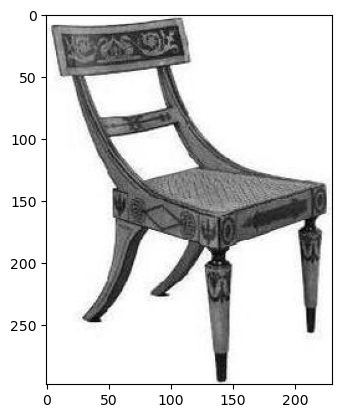

In [17]:
# 이미지 확인하기
import matplotlib.pyplot as plt

plt.imshow(chairData[0].reshape(298, 230), cmap='gray')
plt.show()

##### laptop Image를 numpy로 변경하기

In [18]:
laptopData = np.zeros(
    number_of_data * img_width_size * img_height_size,
    dtype=np.int32
).reshape(
    number_of_data,
    img_height_size,
    img_width_size
)

In [19]:
i = 0
for file in sorted(glob.glob("../Data/laptopNew/*.jpg")):
    img = np.array(Image.open(file), dtype=np.int32)
    laptopData[i,:,:] = img
    i+=1

In [20]:
laptopData.shape

(60, 298, 230)

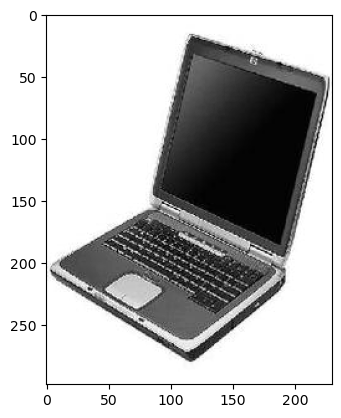

In [21]:
# 이미지 확인하기
plt.imshow(laptopData[0].reshape(298, 230), cmap='gray')
plt.show()

----
#### numpy data를 train data로 합치기

In [22]:
train = np.concatenate(
    [chairData, laptopData]
)
train.shape

(120, 298, 230)

#### target data

In [23]:
target = np.concatenate(
    [np.zeros(60), np.ones(60)]
)
target.shape

(120,)

In [24]:
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [25]:
train = train.reshape(-1,298,230,1) / 255.0

In [56]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

trainData, testData, trainTarget, testTarget = train_test_split(train, target, test_size=0.2, random_state=42)

In [67]:
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(298, 230, 1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(1, activation='sigmoid'))

# model.summary()

mc = ModelCheckpoint("../Data/Keras/0803.h5")
es = EarlyStopping(patience=5, restore_best_weights=True)



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(trainData, trainTarget, 
                    epochs=10, batch_size=20, 
                    validation_data=(testData, testTarget),
                    callbacks=[mc, es])


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5775 - loss: 4.1114

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step - accuracy: 0.5625 - loss: 6.1291 - val_accuracy: 0.4583 - val_loss: 1.9233
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6275 - loss: 1.7953

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 767ms/step - accuracy: 0.5833 - loss: 1.4895 - val_accuracy: 0.5417 - val_loss: 0.6785
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5667 - loss: 0.7799

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - accuracy: 0.5417 - loss: 0.7410 - val_accuracy: 0.5833 - val_loss: 0.6874
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.5846 - loss: 0.6714

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 798ms/step - accuracy: 0.6354 - loss: 0.6694 - val_accuracy: 0.5833 - val_loss: 0.6765
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5196 - loss: 0.7068

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 808ms/step - accuracy: 0.6146 - loss: 0.6916 - val_accuracy: 0.7917 - val_loss: 0.6644
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7133 - loss: 0.6412

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 769ms/step - accuracy: 0.7083 - loss: 0.6345 - val_accuracy: 0.8750 - val_loss: 0.6075
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6875 - loss: 0.5554

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - accuracy: 0.6458 - loss: 0.5896 - val_accuracy: 0.4583 - val_loss: 0.6798
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6304 - loss: 0.7163

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.6562 - loss: 0.6447 - val_accuracy: 0.8750 - val_loss: 0.6060
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8321 - loss: 0.5792

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 766ms/step - accuracy: 0.8021 - loss: 0.5619 - val_accuracy: 0.8750 - val_loss: 0.5398
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.6787 - loss: 0.5948

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 775ms/step - accuracy: 0.7188 - loss: 0.5469 - val_accuracy: 0.8750 - val_loss: 0.4969


In [94]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(6, kernel_size=3, activation='relu', padding='same', input_shape=(298, 230, 1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Flatten())  # <-- 이 부분이 핵심
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(trainData, trainTarget, epochs=10, batch_size=20, validation_data=(testData, testTarget))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.4062 - loss: 1.7947 - val_accuracy: 0.4583 - val_loss: 2.2429
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5417 - loss: 1.3220 - val_accuracy: 0.5417 - val_loss: 0.8247
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5104 - loss: 0.9688 - val_accuracy: 0.7917 - val_loss: 0.6174
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: 0.8389 - val_accuracy: 0.7917 - val_loss: 0.5833
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6875 - loss: 0.5878 - val_accuracy: 0.6250 - val_loss: 0.5983
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7917 - loss: 0.5063 - val_accuracy: 0.7917 - val_loss: 0.5056
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8542 - loss: 0.4319 - val_accuracy: 0.8750 - val_loss: 0.4870
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9271 - loss: 0.3585 - val_accuracy: 0.7917 - val_loss: 0.4322

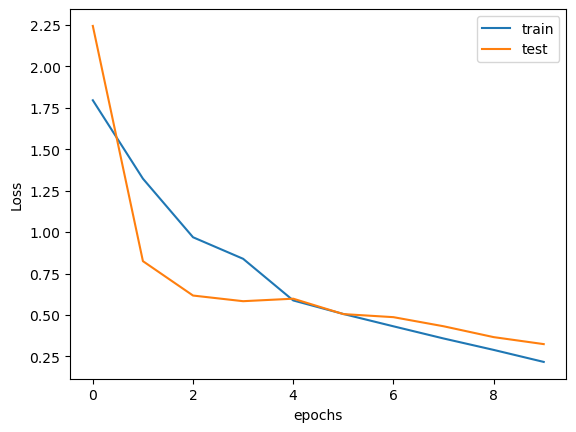

In [95]:
# 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train','test'])
plt.show()

In [96]:
model.evaluate(trainData, trainTarget)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9896 - loss: 0.1538


[0.1537536382675171, 0.9895833134651184]

In [97]:
model.evaluate(testData, testTarget)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8750 - loss: 0.3245


[0.3244791328907013, 0.875]